In [1]:
import numpy as np
np.set_printoptions(threshold=np.inf)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('global_air_pollution_data.csv')
df.head()

,country_name,city_name,aqi_value,aqi_category,co_aqi_value,co_aqi_category,ozone_aqi_value,ozone_aqi_category,no2_aqi_value,no2_aqi_category,pm2.5_aqi_value,pm2.5_aqi_category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


In [3]:
#check info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   country_name        23036 non-null  object
 1   city_name           23462 non-null  object
 2   aqi_value           23463 non-null  int64 
 3   aqi_category        23463 non-null  object
 4   co_aqi_value        23463 non-null  int64 
 5   co_aqi_category     23463 non-null  object
 6   ozone_aqi_value     23463 non-null  int64 
 7   ozone_aqi_category  23463 non-null  object
 8   no2_aqi_value       23463 non-null  int64 
 9   no2_aqi_category    23463 non-null  object
 10  pm2.5_aqi_value     23463 non-null  int64 
 11  pm2.5_aqi_category  23463 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.1+ MB


xem tổng quan như tên các feat và thông tin các mẫu
 - tổng số lượng mẫu, tổng số lượng đặt trưng
 - xem rõ từng đặt trung thuộc kiểu dữ liệu gì và hiện tại có bao nhiêu giá trị, tức là có null hay không (null= tổng - hiện tại)

# xử lý null


In [4]:
count_null = df.isna().sum()
print(count_null)
print('trước khi xóa null: ', df.shape)
df = df.dropna()
print('sau khi xóa null: ', df.shape)

country_name          427
city_name               1
aqi_value               0
aqi_category            0
co_aqi_value            0
co_aqi_category         0
ozone_aqi_value         0
ozone_aqi_category      0
no2_aqi_value           0
no2_aqi_category        0
pm2.5_aqi_value         0
pm2.5_aqi_category      0
dtype: int64
trước khi xóa null:  (23463, 12)
sau khi xóa null:  (23035, 12)


In [5]:
print(427/df.shape[0])

0.01853700889950076


ở đây chọn xóa null vì số lượng mẫu null quá ích so với tổng mẫu với country_name chỉ bằng 0.01853700889950076 
- có nhiều phương pháp xử lý null như 'abc', nhưng chọn xóa null vì 'abc'    
        - vì sao chọn xóa chứ không chọn phương pháp khác 'abc'

# xóa đi dữ liệu trùng 

In [6]:
df = df.drop_duplicates()

tại sao phải xử lý trùng ......?

In [7]:
df.columns

Index(['country_name', 'city_name', 'aqi_value', 'aqi_category',
       'co_aqi_value', 'co_aqi_category', 'ozone_aqi_value',
       'ozone_aqi_category', 'no2_aqi_value', 'no2_aqi_category',
       'pm2.5_aqi_value', 'pm2.5_aqi_category'],
      dtype='object')

# phân tích dữ liệu dạng object (tạm để lại)
chia theo 2 đặt điểm là địa lý và danh mục các loại
- 'country_name', 'city_name' 
- *_aqi_category

In [8]:
#check unique

#country_name
print(df['country_name'].unique(),'\nSum unique: ', len(df['country_name'].unique()))
#city_name
print(df['city_name'].unique(),'\nSum unique: ', len(df['city_name'].unique()) )

['Russian Federation' 'Brazil' 'Italy' 'Poland' 'France'
 'United States of America' 'Germany' 'Belgium' 'Egypt' 'China'
 'Netherlands' 'India' 'Pakistan' 'Republic of North Macedonia' 'Colombia'
 'Romania' 'Indonesia' 'Finland' 'South Africa'
 'United Kingdom of Great Britain and Northern Ireland'
 'United Republic of Tanzania' 'Haiti' 'Somalia' 'Philippines' 'Latvia'
 'Chad' 'New Zealand' 'Tunisia' 'Viet Nam' 'Iran (Islamic Republic of)'
 'Mexico' 'Japan' 'El Salvador' 'Bulgaria' 'Nigeria' 'South Sudan'
 'Guatemala' 'Ireland' 'Turkey' 'Peru' 'Democratic Republic of the Congo'
 'Canada' 'Switzerland' 'Denmark' 'Cameroon' 'Australia' 'Portugal'
 "Côte d'Ivoire" 'Sweden' 'Ethiopia' 'Thailand' 'Hungary' 'Kazakhstan'
 'Israel' 'Spain' 'Myanmar' 'Papua New Guinea' 'Madagascar' 'Lithuania'
 'Ghana' 'Azerbaijan' 'Armenia' 'Ukraine' 'Malaysia' 'Serbia' 'Slovakia'
 'Gambia' 'Ecuador' 'Bosnia and Herzegovina' 'Czechia' 'Argentina'
 'Dominican Republic' 'Guinea' 'Bolivia (Plurinational State of)

số lượng city ngang bằng  so với lượng dữ liệu có sẵn(23035), điều này có thể ảnh hưởng đến hiệu suất đào tạo nếu chúng ta phải mã hóa đặc điểm phân loại này thành các vectơ one-hot (ví dụ bằng cách sử dụng OneHotEncoder). sẽ không giúp ích gì nhiều trong mô hình 
Ngược lại, 'country' Số lượng country khá  tốt, vì vậy sử dụng country  thay vì [city] làm thông tin địa lý để tăng độ khái quát.


In [9]:
# drop column city
df.drop("city_name", axis=1, inplace=True)

In [10]:
#check tính nhất quán về kí tự và sự tồn của country 

country = df['country_name'].unique()

# sort them alphabetically and then take a closer look
country.sort()
country
print(country)


# kiểm tra xem mỗi một quốc gia có bao nhiêu mẫu 
df['country_name'].value_counts()

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Argentina'
 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan' 'Bahrain'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' "Côte d'Ivoire" 'Democratic Republic of the Congo' 'Denmark'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Finland' 'France' 'Gabon' 'Gambia'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau'
 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran (Islamic Republic of)' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica'
 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kingdom of Eswatini' 'Kuwait'
 'Kyrgyzstan' "

country_name
United States of America    2872
India                       2488
Brazil                      1562
Germany                     1345
Russian Federation          1241
                            ... 
Bahrain                        1
Seychelles                     1
State of Palestine             1
Saint Kitts and Nevis          1
Monaco                         1
Name: count, Length: 175, dtype: int64

# giữ lại các feat numberic và label xóa đi object

Đặc trưng địa lý:
- country_name và city_name:
    - Lý do loại bỏ: Nếu mô hình của bạn không cần tính đến yếu tố địa lý cụ thể mà chỉ tập trung vào chất lượng không khí thì các cột này có thể bỏ đi để giảm kích thước dữ liệu. Ngoài ra, city_name thường chứa nhiều giá trị duy nhất (unique) và có thể phức tạp khi mã hóa thành các biến số.

Đặc trưng chất lượng không khí tổng thể:
-   aqi_value và aqi_category:
    - Vì là biến mục tiêu cần giữ aqi_category (loại không khí) và có thể loại bỏ aqi_value (giá trị AQI).

Các chỉ số AQI theo chất khí riêng lẻ:
-    co_aqi_value, ozone_aqi_value, no2_aqi_value, pm2.5_aqi_value:
        -  Lý do giữ: Những đặc trưng này đại diện cho mức độ ô nhiễm của từng loại khí và giúp mô hình phân lớp chính xác hơn khi xem xét từng loại khí ảnh hưởng đến chất lượng không khí.

Danh mục chất lượng của từng loại khí:
 -   co_aqi_category, ozone_aqi_category, no2_aqi_category, pm2.5_aqi_category:
        - Lý do loại bỏ: Nếu bạn đã giữ các giá trị AQI riêng cho từng chất khí (co_aqi_value, ozone_aqi_value, v.v.), các đặc trưng phân loại này có thể được loại bỏ, tránh dư thừa thông tin khi mô hình có thể dựa vào giá trị AQI cụ thể thay vì danh mục.
Đề xuất chọn:
  -  Giữ lại: aqi_category, co_aqi_value, ozone_aqi_value, no2_aqi_value, pm2.5_aqi_value.Giữ aqi_category để làm biến mục tiêu cho bài toán phân lớp, và các *_aqi_value để mô hình có thể sử dụng dữ liệu chi tiết về nồng độ từng loại khí.
   - Có thể bỏ đi: country_name, city_name, aqi_value, co_aqi_category, ozone_aqi_category, no2_aqi_category, pm2.5_aqi_category.
    city_name và country_name có thể bỏ nếu không có giá trị địa lý cụ thể; aqi_value bỏ vì có aqi_category; và các *_aqi_category bỏ vì có thể dựa vào *_aqi_value để phân loại.

In [11]:
df = df[['aqi_category', 'co_aqi_value','no2_aqi_value','ozone_aqi_value', 'pm2.5_aqi_value']]
df

,aqi_category,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
0,Moderate,1,0,36,51
1,Good,1,1,5,41
2,Moderate,1,2,39,66
3,Good,1,0,34,20
4,Good,0,0,22,6
...,...,...,...,...,...
23458,Unhealthy,3,2,154,184
23459,Good,1,5,20,50
23460,Good,1,1,22,50
23461,Moderate,1,2,44,71


# Phân tích dữ liệu số

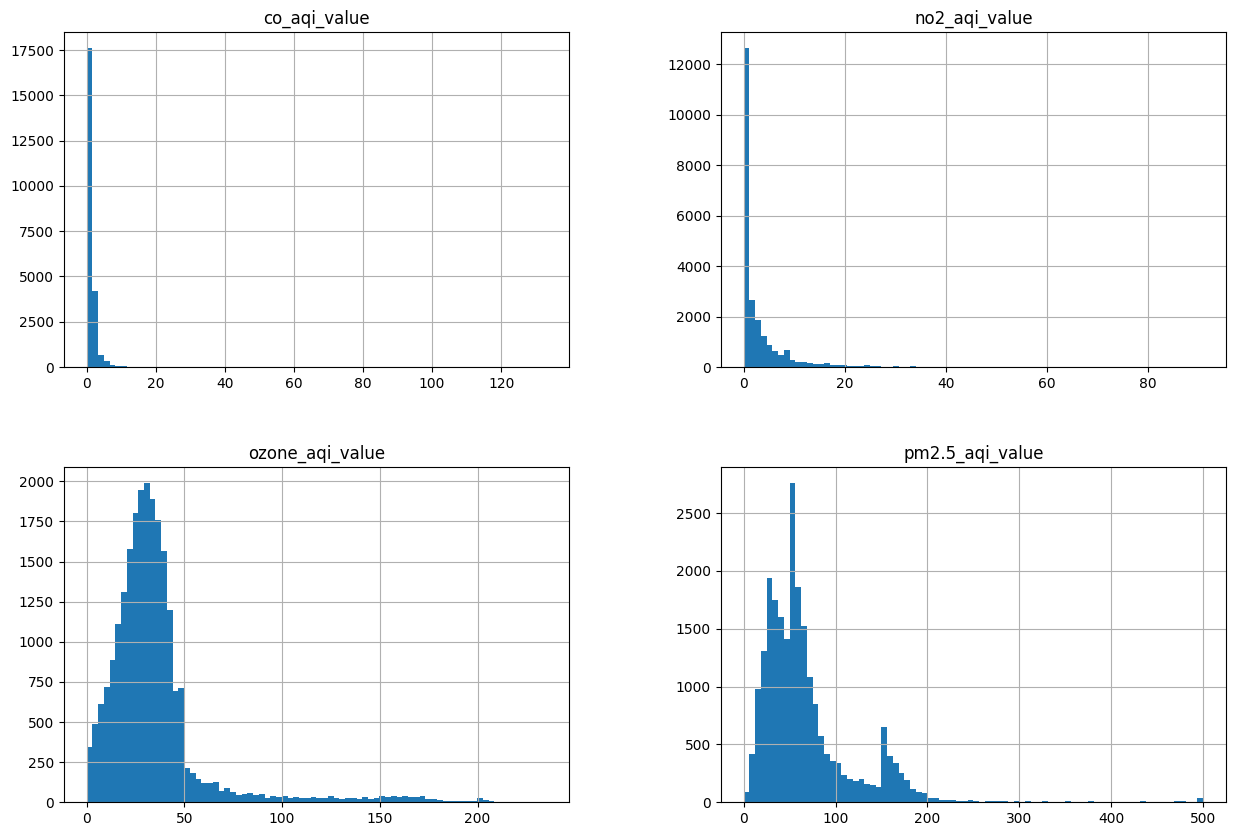

In [12]:
# histogram cho numberic
df.hist(bins=80, figsize=(15, 10))
plt.show() 

quan sát histogram có phần phân bố không điều, lệch trái -> chuyển đổi dữ liệu Normalization
- có nhiều cách chuyển đổi như box-cox và 'abc' tại sao không dùng thằng khác? so saschsh giải tích ....

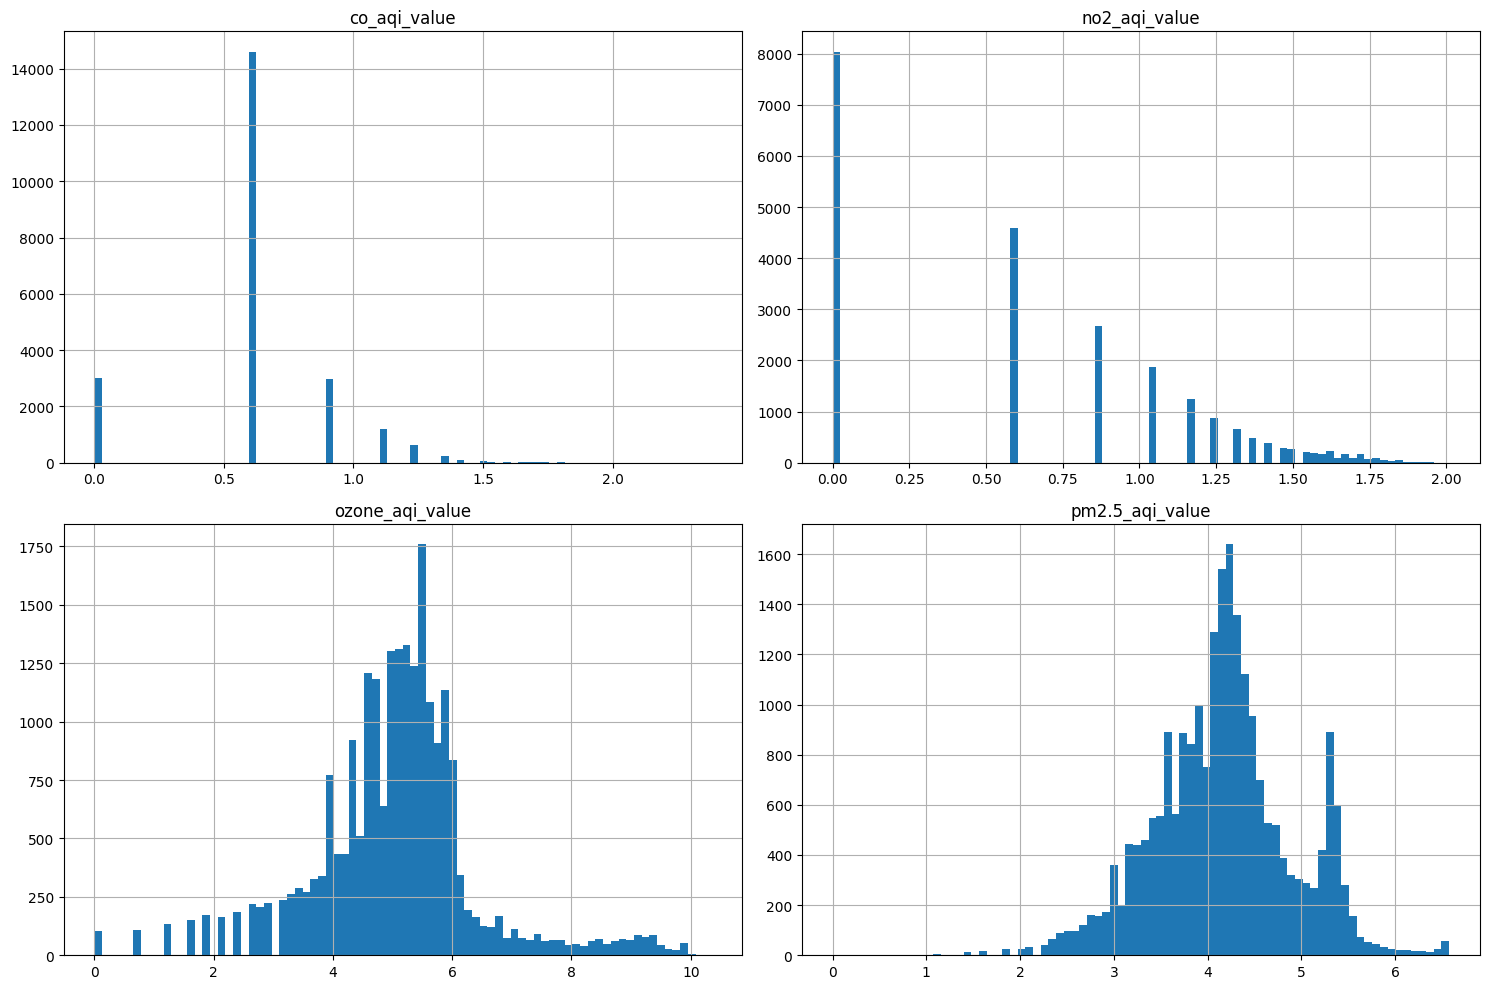

In [13]:

# Chọn các biến số để chuẩn hóa (loại bỏ nhãn 'aqi_category')
input_data = df[['co_aqi_value', 'no2_aqi_value', 'ozone_aqi_value', 'pm2.5_aqi_value']]

# Kiểm tra và điều chỉnh dữ liệu nếu có giá trị <= 0
input_data = input_data.apply(lambda x: x + 1 if (x <= 0).any() else x)

# Áp dụng Box-Cox transformation cho từng cột và lưu kết quả
normalized_data = input_data.apply(lambda x: stats.boxcox(x)[0])

# Gán lại các cột đã chuẩn hóa vào DataFrame ban đầu
df[['co_aqi_value', 'no2_aqi_value', 'ozone_aqi_value', 'pm2.5_aqi_value']] = normalized_data

# Vẽ biểu đồ so sánh phân phối trước và sau khi chuẩn hóa
df.hist(bins=80, figsize=(15, 10))
plt.tight_layout()
plt.show()


In [14]:
df.describe()

,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
count,23035.000000,23035.000000,23035.000000,23035.000000
mean,0.641214,0.663808,5.024261,4.163393
std,0.323717,0.565956,1.399156,0.736259
min,0.000000,0.000000,0.000000,0.000000
25%,0.617284,0.000000,4.374279,3.701014
50%,0.617284,0.600441,5.127794,4.154640
75%,0.617284,1.165933,5.660284,4.558567
max,2.379857,2.009582,10.339132,6.575886


# kiểm tra tương quan của các biến numberic

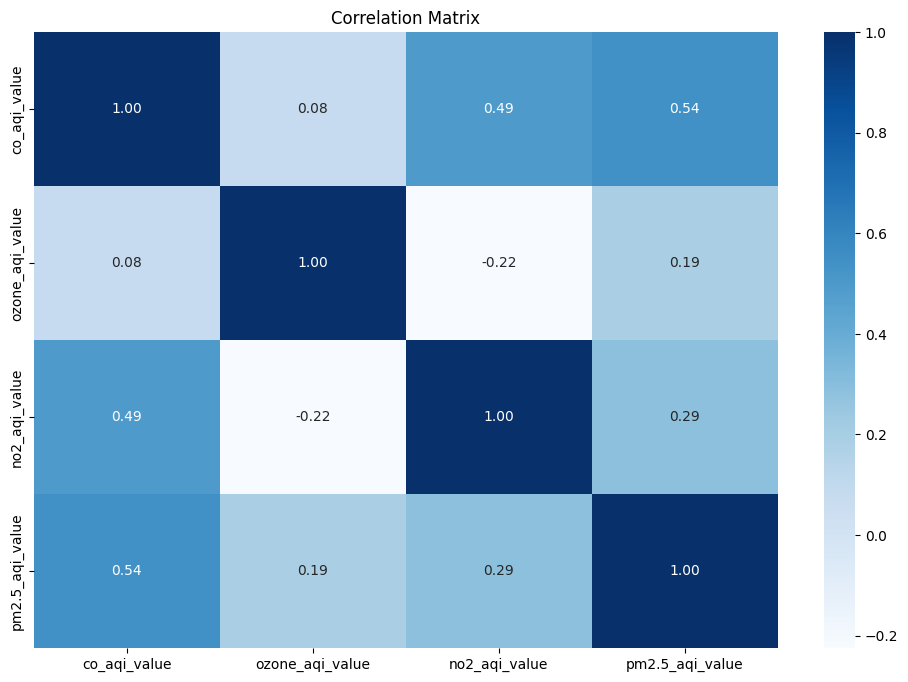

In [15]:
correlation_matrix = df[[ 'co_aqi_value', 'ozone_aqi_value', 'no2_aqi_value', 'pm2.5_aqi_value']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True,cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


giải thích bảng tuogn quang trên <br>
giữ lại các thuộc tính trên, các cặp thuộc tính không có tương quan dương và âm trên 0.8 nên giữ, nếu >0.8 xóa đi vì .....

# convert label to numberic 

In [16]:
label_encoder = LabelEncoder()

df['aqi_category'] = label_encoder.fit_transform(df['aqi_category'])

# Hiển thị các nhãn và giá trị tương ứng sau khi chuyển đổi
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping của các nhãn chữ sang số:", label_mapping)

df.head()

Mapping của các nhãn chữ sang số: {'Good': np.int64(0), 'Hazardous': np.int64(1), 'Moderate': np.int64(2), 'Unhealthy': np.int64(3), 'Unhealthy for Sensitive Groups': np.int64(4), 'Very Unhealthy': np.int64(5)}


,aqi_category,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
0,2,0.617284,0.000000,5.436310,4.094407
1,0,0.617284,0.600441,2.181700,3.865609
2,2,0.617284,0.877936,5.605961,4.367059
3,0,0.617284,0.000000,5.317094,3.129055
4,0,0.000000,0.000000,4.460560,1.980216


# final preprocessing

In [17]:
df

,aqi_category,co_aqi_value,no2_aqi_value,ozone_aqi_value,pm2.5_aqi_value
0,2,0.617284,0.000000,5.436310,4.094407
1,0,0.617284,0.600441,2.181700,3.865609
2,2,0.617284,0.877936,5.605961,4.367059
3,0,0.617284,0.000000,5.317094,3.129055
4,0,0.000000,0.000000,4.460560,1.980216
...,...,...,...,...,...
23458,3,1.104568,0.877936,9.051315,5.472181
23459,0,0.617284,1.254504,4.284855,4.073568
23460,0,0.617284,0.600441,4.460560,4.073568
23461,2,0.617284,0.877936,5.867670,4.444712


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23035 entries, 0 to 23462
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aqi_category     23035 non-null  int64  
 1   co_aqi_value     23035 non-null  float64
 2   no2_aqi_value    23035 non-null  float64
 3   ozone_aqi_value  23035 non-null  float64
 4   pm2.5_aqi_value  23035 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.1 MB


c:\Users\nhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


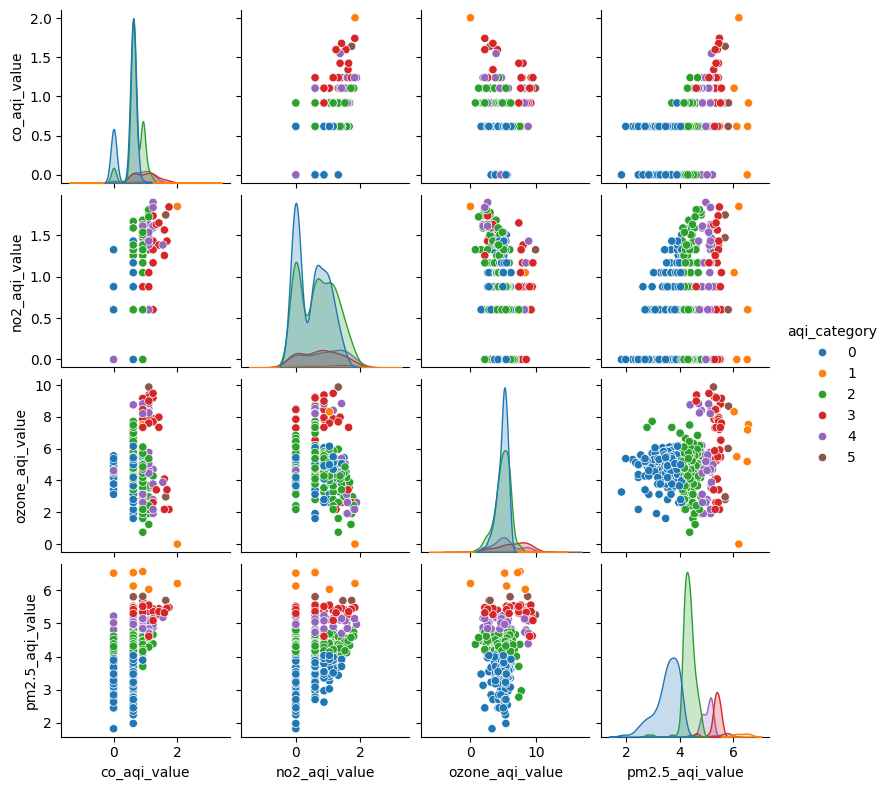

In [19]:
# vẽ pairplot với nhâu nhiên 500 maaux trong dataset
df_sample = df.sample(n=500, random_state=42)
palette = sns.color_palette("tab10", 6)
# Vẽ pair plot
sns.pairplot(data= df_sample,height=2, hue='aqi_category', palette=palette, size=2)
plt.show()

# Chia tập dữ liệu 

In [20]:
# Đặt tỷ lệ chia dữ liệu
train_size = 0.7      # 70% cho training
val_size_relative = 2 / 3   # 20% của dữ liệu còn lại (30%) là validation => 2/3 của 30% 
test_size_relative = 1 / 3   # 10% của dữ liệu ban đầu là test => 1/3 của 30%

# Bước 1: Chia dữ liệu thành tập training và temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(df.iloc[:,1:],df.iloc[:,0], test_size=1 - train_size, random_state=42)

# Bước 2: Chia temporary thành validation và test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size_relative, random_state=42)

kiểm tra cân bằng dữ liệu

In [21]:
y_train.value_counts()

aqi_category
0    6810
2    6319
3    1602
4    1065
5     199
1     129
Name: count, dtype: int64

# sử dung smote để cân bằng dữ liệu
tại sao không phải phương pháp khác có nhiều pp như up, down nhưng tại sao lại chọn pp này hãy trình bày cho phù hợp với bài toán

In [22]:
# Áp dụng SMOTE để cân bằng dữ liệu trên tập training
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Kiểm tra số lượng mẫu trong mỗi lớp sau khi SMOTE
print("Số lượng mẫu trong tập train của mỗi lớp sau khi áp dụng SMOTE:")
y_train.value_counts()

Số lượng mẫu trong tập train của mỗi lớp sau khi áp dụng SMOTE:


aqi_category
2    6810
0    6810
4    6810
5    6810
3    6810
1    6810
Name: count, dtype: int64

# Scaling

chọn so sanhs 2 pp scaling và tại sao chọn phương pháp này nọ lọ chai giả tích phù hợp với bài toán

In [23]:
# Khởi tạo StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Train 

In [24]:
# from softmax_function import SoftmaxRegression
from softmax_mini_batch import SoftmaxRegression

# Khởi tạo và huấn luyện mô hình
softmax_model = SoftmaxRegression(learning_rate=0.1, n_iter=1000,batch_size= 32)
softmax_model.fit(X_train, y_train, X_val, y_val)

Epoch 0, Training Loss: 1.6012, Validation Loss: 1.4779, Training Acc: 0.4813, Validation Acc: 0.5255
Epoch 100, Training Loss: 0.5673, Validation Loss: 0.5577, Training Acc: 0.8189, Validation Acc: 0.8624
Epoch 200, Training Loss: 0.5174, Validation Loss: 0.4742, Training Acc: 0.8516, Validation Acc: 0.8719
Epoch 300, Training Loss: 0.4808, Validation Loss: 0.4336, Training Acc: 0.8682, Validation Acc: 0.8815
Epoch 400, Training Loss: 0.5423, Validation Loss: 0.4030, Training Acc: 0.8744, Validation Acc: 0.8860
Epoch 500, Training Loss: 0.4396, Validation Loss: 0.3849, Training Acc: 0.8787, Validation Acc: 0.8863
Epoch 600, Training Loss: 0.3747, Validation Loss: 0.3713, Training Acc: 0.8808, Validation Acc: 0.8871
Epoch 700, Training Loss: 0.5280, Validation Loss: 0.3564, Training Acc: 0.8865, Validation Acc: 0.8939
Epoch 800, Training Loss: 0.3368, Validation Loss: 0.3490, Training Acc: 0.8873, Validation Acc: 0.8926
Epoch 900, Training Loss: 0.4104, Validation Loss: 0.3427, Trainin

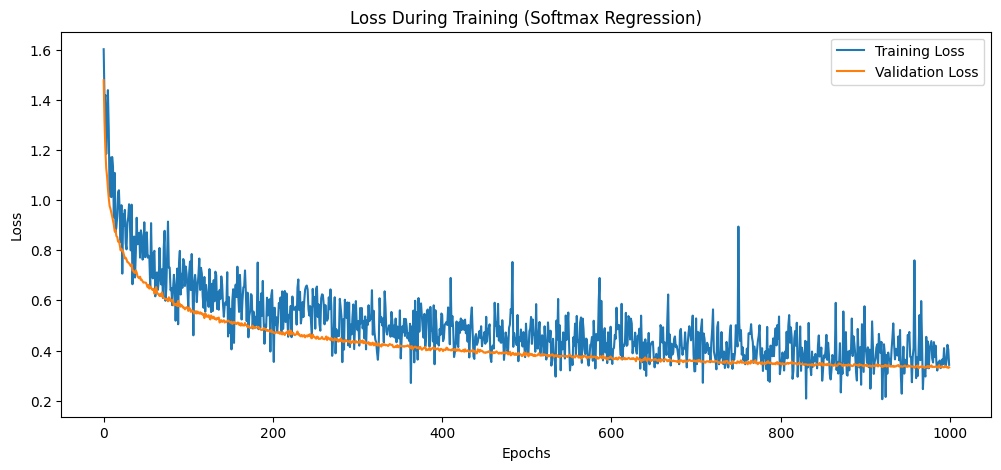

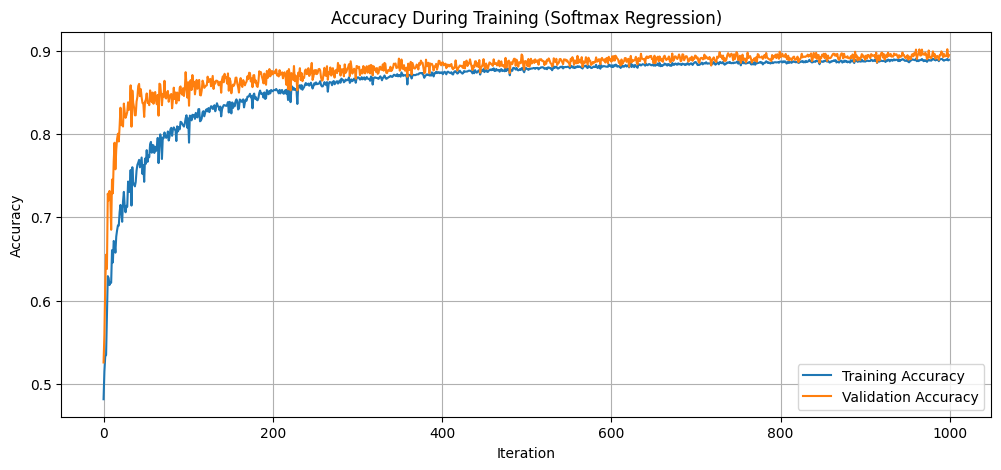

In [25]:
# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))
plt.plot(range(softmax_model.n_iter), softmax_model.training_losses, label='Training Loss')
plt.plot(range(softmax_model.n_iter), softmax_model.validation_losses, label='Validation Loss')
plt.title('Loss During Training (Softmax Regression)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(softmax_model.n_iter), softmax_model.training_accuracies, label='Training Accuracy')
plt.plot(range(softmax_model.n_iter), softmax_model.validation_accuracies, label='Validation Accuracy')
plt.title('Accuracy During Training (Softmax Regression)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

In [26]:
y_pred_softmax = softmax_model.predict(X_test)
accuracy_softmax = accuracy_score(y_test, y_pred_softmax)
print(f"Softmax Regression Accuracy: {accuracy_softmax:.4f}")
print(classification_report(y_test, y_pred_softmax))

Softmax Regression Accuracy: 0.9045
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       945
           1       0.89      1.00      0.94        25
           2       0.93      0.90      0.91       938
           3       0.90      0.79      0.84       199
           4       0.69      0.90      0.78       165
           5       0.44      0.78      0.56        32

    accuracy                           0.90      2304
   macro avg       0.80      0.88      0.83      2304
weighted avg       0.91      0.90      0.91      2304

